N=1000
M=7
START


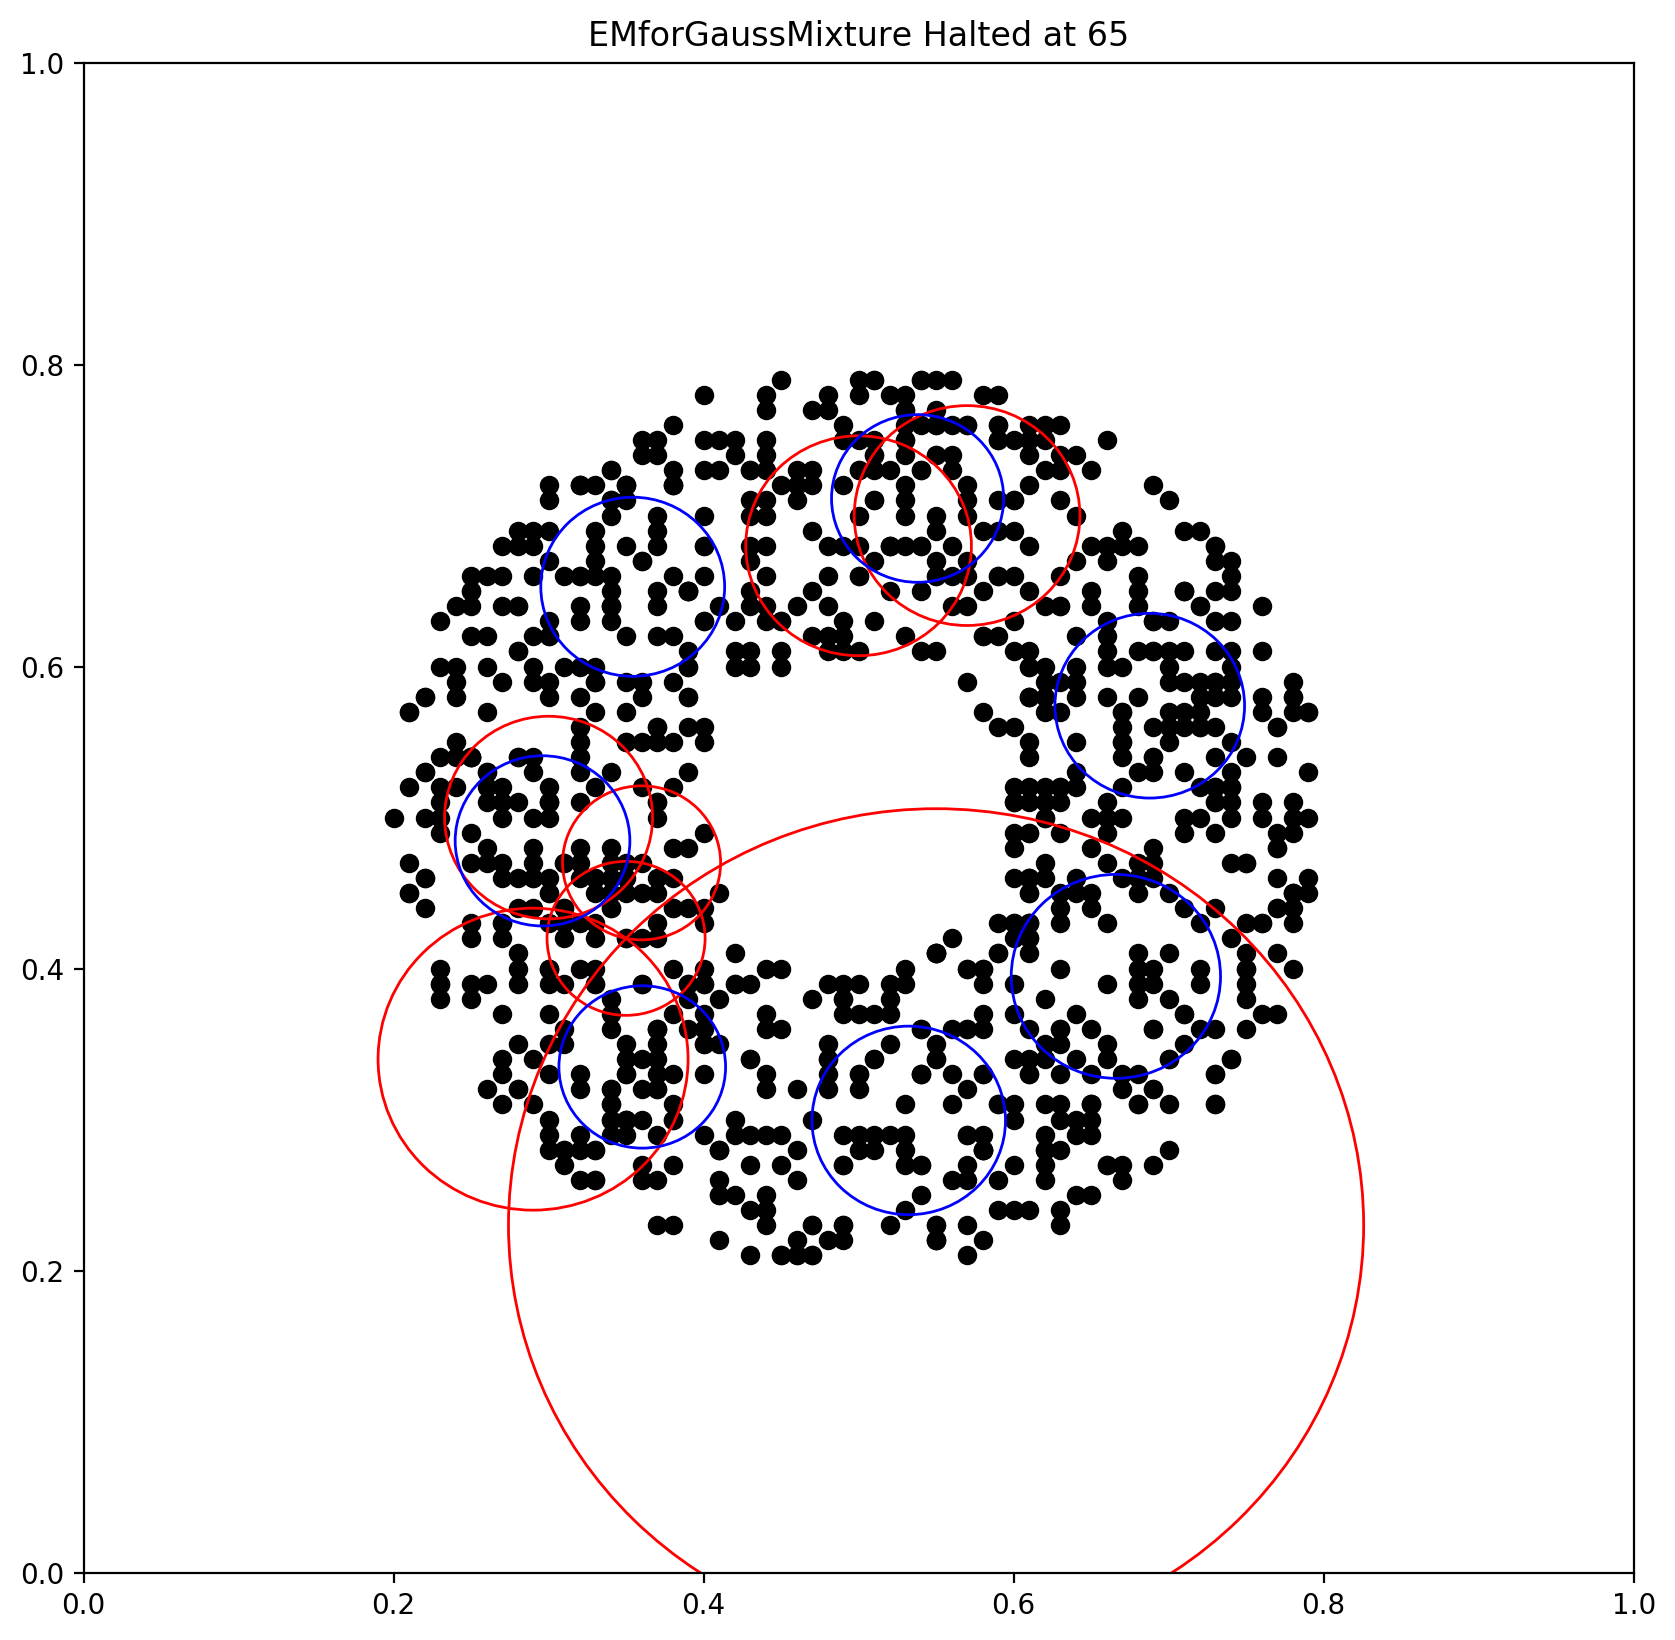

END


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import random
import matplotlib.patches as patches
from decimal import Decimal, ROUND_HALF_UP

def range_check(x,y):
    center_x=0.5
    center_y=0.5
    out_r=0.3
    in_r=0.1
    if(pow(x-center_x,2)+pow(y-center_y,2)<=pow(in_r,2)):
        return False
    elif(pow(x-center_x,2)+pow(y-center_y,2)>pow(out_r,2)):
        return False
    else:
        return True


#Nx2
def random_generator(N=1000):
    points=[]
    count=0
    tx=[]
    ty=[]
    while(count<N):
        x=0
        y=0
        while(not range_check(x,y)):
            if(count>N):
                break
            if(count>0):
                x=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
                y=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
                if(x in tx):
                    x=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
                    continue
                elif(y in ty):
                    y=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
                    continue
            else:
                x=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
                y=float(Decimal(np.random.rand(1)[0]).quantize(Decimal('0.01'),rounding=ROUND_HALF_UP))
        tx.append(x)
        ty.append(y)
        count=count+1
    points.append(tx)
    points.append(ty)
    return points

def random_selection(M=7,N=1000):
    selection=[]
    for i in range(M):
        r=random.randint(0,N-1)
        while(r in selection):
            r=random.randint(0,N-1)
        selection.append(r)
    return selection

def draw_circle(x=0.5,y=0.5,r=0.4):
    ax=plt.axes()
    circle=plt.Circle((x,y),r,ec="r",fill=False)
    ax.add_patch(circle)
    return circle

def EM(points,index_select):
    #init
    dim=2
    calculate_count=1
    Th=0.001
    sigma_new=[]
    mu_new=[]
    mu_oldx=[]
    px=[]
    py=[]
    P_j=[] #P_old( j )
    PDF=[] #P_old(j|x_n)
    pdf=[] #p_old(x_n| j )
    p_old=[] #p_old(x_n)
    p_new=[] #p_new(x_n)
    P_new=[] #P_new( j )
    new_pdf=[] #p_new(x_n| j )
    M=len(index_select)
    N=len(points[0])
    for j in range(M):
        P_j.append(1.0/M)
        #calculate nearest distance
        d_min=10000000
        for k in range(M):
            if(not j==k):
                distance=np.sqrt(pow(points[0][index_select[j]]-points[0][index_select[k]],2)+pow(points[1][index_select[j]]-points[1][index_select[k]],2))
                if(distance<d_min):
                    d_min=distance
        sigma_new.append(d_min*d_min)
        px.append(points[0][index_select[j]])
        py.append(points[1][index_select[j]])
        draw_circle(points[0][index_select[j]],points[1][index_select[j]],np.sqrt(sigma_new[j]))
    mu_new.append(px)
    mu_new.append(py)
    
    #calculate p_old(x_n| j )
    for j in range(M):
        t_pdf=[]
        for n in range(N):
            t_pdf.append((1.0/pow(2.0*np.pi*sigma_new[j],dim/2))*np.exp(-(pow(points[0][n]-mu_new[0][j],2)
                                                                     +pow(points[1][n]-mu_new[1][j],2))/(2.0*sigma_new[j])))
        pdf.append(t_pdf)
            
    #calculate P_old(j | x_n)
    for n in range(N):
        S=0
        t_PDF=[]
        for j in range(M):
            S+=pdf[j][n]*P_j[j]
        for j in range(M):
            if(S!=0):
                t_PDF.append(pdf[j][n]*P_j[j]/S)
            else:
                t_PDF.append(0)
        PDF.append(t_PDF)
    
    
    #calculate mu
    for j in range(M):
        sx=0
        sy=0
        t=0
        for n in range(N):
            sx+=PDF[n][j]*points[0][n]
            sy+=PDF[n][j]*points[1][n]
            t+=PDF[n][j]
        mu_oldx.append(mu_new[0][j])
        mu_new[0][j]=sx/t
        mu_new[1][j]=sy/t
    
    #calculate sigma^2
    for j in range(M):
        s=0
        t=0
        for n in range(N):
            s+=PDF[n][j]*(pow(points[0][n]-mu_new[0][j],2)+pow(points[1][n]-mu_new[1][j],2))
            t+=PDF[n][j]
        sigma_new[j]=s/(dim*t)
    
    #calculate p_old(x_n)
    for n in range(N):
        sp=0
        for j in range(M):
            sp+=pdf[j][n]*P_j[j]
        p_old.append(sp)
    
    #calculate P_new( j )
    for j in range(M):
        s=0
        for n in range(N):
            s+=PDF[n][j]
        P_new.append(s/N)
    
    #calculate p_new(x_n| j)
    for j in range(M):
        t_pdf_new=[]
        for n in range(N):
            t_pdf_new.append((1.0/pow(2.0*np.pi*sigma_new[j],dim/2))*np.exp(-(pow(points[0][n]-mu_new[0][j],2)
                                                                     +pow(points[1][n]-mu_new[1][j],2))/(2.0*sigma_new[j])))
        new_pdf.append(t_pdf_new)
    
    #calculate p_new(x_n)
    for n in range(N):
        tmp=0
        for j in range(M):
            tmp+=new_pdf[j][n]*P_new[j]
        p_new.append(tmp)
    
    #calculate diff : Enew-Eold
    diff=0
    for j in range(M):
        diff+=abs(mu_new[0][j]-mu_oldx[j])
    #print(diff)
    
    ##################################
    ##Until  |E_new-E_old|<Th more than 2 counts
    ##################################
    while(diff>=Th):
        #P_old(j |x_n) update PDF
        for n in range(N):
            S=0
            for j in range(M):
                S+=new_pdf[j][n]*P_new[j]
            for j in range(M):
                if(S!=0):
                    t_PDF[j]=new_pdf[j][n]*P_new[j]/S
                else:
                    t_PDF[j]=0
            PDF[n]=t_PDF[:]
        
        #calculate p_old(x_n)
        for n in range(N):
            sp=0
            for j in range(M):
                sp+=new_pdf[j][n]*P_new[j]
            p_old[n]=sp
        
        #mu_new update mu_new
        for j in range(M):
            S2x=0
            S2y=0
            S2_tmp=0
            for n in range(N):
                S2x+=PDF[n][j]*points[0][n]
                S2y+=PDF[n][j]*points[1][n]
                S2_tmp+=PDF[n][j]
            mu_oldx[j]=mu_new[0][j]
            mu_new[0][j]=S2x/S2_tmp
            mu_new[1][j]=S2y/S2_tmp
        
        #sigma^2_new update sigma_new
        for j in range(M):
            s=0
            t=0
            for n in range(N):
                s+=PDF[n][j]*(pow(points[0][n]-mu_new[0][j],2)+pow(points[1][n]-mu_new[1][j],2))
                t+=PDF[n][j]
            sigma_new[j]=s/(dim*t)

        #P_new( j )
        for j in range(M):
            s=0
            for n in range(N):
                s+=PDF[n][j]
            P_new[j]=s/N
        
        #p_new(x_n| j )
        for j in range(M):
            for n in range(N):
                t_pdf_new[n]=((1.0/pow(2.0*np.pi*sigma_new[j],dim/2))*np.exp(-(pow(points[0][n]-mu_new[0][j],2)
                                                                     +pow(points[1][n]-mu_new[1][j],2))/(2.0*sigma_new[j])))
            new_pdf[j]=t_pdf_new[:]
        
        #p_new(x_n)
        for n in range(N):
            tmp=0
            for m in range(M):
                tmp+=new_pdf[j][n]*P_new[j]
            p_new[n]=tmp

        #Update diff
        diff=0
        for j in range(M):
            diff+=abs(mu_new[0][j]-mu_oldx[j])
        #print(diff)
        
        plt.title(calculate_count)
        calculate_count+=1
    
    #plot
    for i in range(M):
        ax=plt.axes()
        circle=plt.Circle((mu_new[0][i],mu_new[1][i]),np.sqrt(sigma_new[i]),ec="b",fill=False)
        ax.add_patch(circle)
    ax.set_title("EMforGaussMixture Halted at {}".format(calculate_count))
#########################
##main
#########################
N=int(input("N="))
M=int(input("M="))
print("START")
points=random_generator(N)
select_points=random_selection(M,N)
fig=plt.figure(figsize=(10,10),dpi=200)
plt.scatter(points[0],points[1],c="black")
EM(points,select_points)
plt.axis([0,1,0,1])
plt.show()
print("END")
